# Exploring LSST Cadence per year

LSST has a complex survey strategy and the realised cadence varies significantly as a function of sky position, year of survey and filter. 
The purpose of this notebook is to illustrate the observations that LSST will produce as a tunable function of these parameters. 

In [7]:
import os
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column
from astropy.io import ascii
import rubin_sim.phot_utils as phot_utils
import rubin_sim.maf as maf
from rubin_sim.phot_utils import signaltonoise, PhotometricParameters
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline
import healpy as hp
from scipy.interpolate import interp1d

## Target Parameters 

To explore what LSST will produce for our (sidereal) target of interest, let's take a "typical" example.

In [2]:
# Target coordinates
#target = SkyCoord('11:51:01.80', '-28:44:38.48', frame='icrs', unit=(u.hourangle, u.deg))
target = SkyCoord('20:51:01.80', '-22:44:38.48', frame='icrs', unit=(u.hourangle, u.deg))

Ra = target.ra.deg
Dec = target.dec.deg

print('Target sky location: RA=' + str(Ra) + 'deg, Dec=' + str(Dec))

# Target distance in parsecs, modulus in mag
distance = 22.4e6
distance_modulus = 31.75

# Extinction in that direction [mags]
Av = 0.29

Target sky location: RA=312.7575deg, Dec=-22.744022222222224


## Load the LSST Survey Simulation

Rubin Observatory has generated a sophisticated simulation of the survey in action.  The resulting set of simulated observations is available as sn SQLite database from [this archive](https://usdf-maf.slac.stanford.edu/?runId=2).  

Here we load the latest survey simulation, and extract from it the MJD dates of observation, filters used and the limiting magnitude reached.

In [3]:
# Load the opsim database
baseline_file = '/Users/rstreet/rubin_sim_data/sim_baseline/baseline_v5.0.1_10yrs.db'
name = os.path.basename(baseline_file).replace('.db','')

outDir = 'temp'
resultsDb = maf.db.ResultsDb()

# This section selects which columns from the database will be loaded - in this case, the information on the 
# bandpass and MJD of each exposure, together with the 5sigma limiting magnitude.  
# We provide the target sky location at this point, so that we get the sequence of exposures corresponding to the 
# component survey(s) that cover that location.
bundleList = []
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=[Ra], dec=[Dec])
bundleList.append(maf.MetricBundle(metric, slicer, sql))

example1_bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
example1_bg.run_all()
dataSlice = bundleList[0].metric_values[0]

# Rubin filterset, and the single-visit limiting magnitude in each of those filters
filters = ['u', 'g', 'r', 'i', 'z', 'y']
mag_limit = {'u': 23.7, 'g': 24.97, 'r': 24.52, 'i': 24.13, 'z': 23.56, 'y': 22.55}

We're also going to need to know the starting and end MJDs of the LSST survey itself, in order to estimate when different years of the survey start and finish. 

In [4]:
rubin_mjd_min = dataSlice['observationStartMJD'].min()
rubin_mjd_max = dataSlice['observationStartMJD'].max()
print('MJD of LSST start: ' + str(rubin_mjd_min))
print('MJD of LSST finish: ' + str(rubin_mjd_max))

MJD of LSST start: 61025.03173059682
MJD of LSST finish: 64624.102493799415


In [5]:
survey_years_start = np.array([rubin_mjd_min + n*365.24 for n in range(0,10,1)])
survey_years_end = survey_years_start + 365.24
survey_years_end[-1] = min(survey_years_end[-1], rubin_mjd_max)

## Survey Cadence Per Filter Per Year

A common question is "how often will LSST observe [my favorite target]?".  This is complicated to answer because the interval between observations is not rigidly fixed, but a distribution that depends on sky location and filter.  It also depends on what year of the survey is considered, particularly for high-latitude regions.  

Here we explore what this means for our example target as a function of filter and year. 

In [6]:
obs_intervals = {}
for i,f in enumerate(filters):
    data = []
    for year in range(0,10,1):
        
        # Mask to select observations in the current year and filter:
        mask = (dataSlice['filter'] == f) \
            & (dataSlice['observationStartMJD'] >= survey_years_start[year]) \
            & (dataSlice['observationStartMJD'] < survey_years_end[year])

        # Calculate statistics on the intervals between observations in different filters
        ts = np.sort(dataSlice['observationStartMJD'][mask])
        delta_ts = ts[1:] - ts[0:-1]

        if len(delta_ts) > 1:
            data.append([np.median(delta_ts), delta_ts.std(), len(ts), delta_ts.min(), delta_ts.max()])
        elif len(delta_ts) == 1:
            data.append([np.median(delta_ts), delta_ts.std(), len(ts), delta_ts[0], delta_ts[0]])
        elif len(delta_ts) == 0:
            data.append([np.median(delta_ts), delta_ts.std(), len(ts), np.nan, np.nan])
            
    data = np.array(data)
    results = Table([
            Column(name='Year', data=range(1,11,1)),
            Column(name='Median_interval', data=data[:,0]),
            Column(name='StdDev_interval', data=data[:,1]),
            Column(name='Min_interval', data=data[:,3]), 
            Column(name='Max_interval', data=data[:,4]),
            Column(name='Nobs', data=data[:,2])
        ])
    
    obs_intervals[f] = results

obs_intervals

{'u': <Table length=10>
  Year   Median_interval     StdDev_interval   ...     Max_interval       Nobs 
 int64       float64             float64       ...       float64        float64
 ----- -------------------- ------------------ ... -------------------- -------
     1    2.386220063221117 11.924319758155097 ...   28.942252583983645     5.0
     2 0.000518015309353359                0.0 ... 0.000518015309353359     2.0
     3     7.94387317829387 11.584323323874358 ...    28.98899485284346     4.0
     4    33.88201080584622  43.27120557672628 ...   106.93214491784602     5.0
     5   114.90331398523267                0.0 ...   114.90331398523267     2.0
     6   3.9457815813366324 16.756718943924547 ...   48.868148274523264    10.0
     7    33.95702653794433 14.898682383168227 ...    62.76444665250892     4.0
     8    29.92408450759831                0.0 ...    29.92408450759831     2.0
     9   2.6250422009034082  9.780173237406391 ...   24.924479524066555     9.0
    10    6.0487

In [8]:
# Output observation interval data
ascii.write(obs_intervals, '/Users/rstreet/cassiopeia/GrantProposals/2025/NSF_AAG/Howell_SNe/obs_interval1.dat', overwrite=True)

In [12]:
# Calculate the median interval between observation for each filter 
print('Median interval between observations:')
for i,f in enumerate(filters):
    
    # Mask to select observations in the current year and filter:
    mask = dataSlice['filter'] == f
    
    # Calculate statistics on the intervals between observations in different filters
    ts = np.sort(dataSlice['observationStartMJD'][mask])
    delta_ts = ts[1:] - ts[0:-1]

    print(f + ': ' 
          + str(round(np.median(delta_ts),1)) 
          + ', stddev: ' + str(round(delta_ts.std(),1)) + 'days')

Median interval between observations:
u: 24.0, stddev: 105.3days
g: 6.1, stddev: 108.4days
r: 3.0, stddev: 47.7days
i: 3.0, stddev: 42.6days
z: 5.9, stddev: 45.3days
y: 1.8, stddev: 48.5days


Now we can visualize these statistics...

In [14]:
PLOT_COLORS = {
    "u": "#3303ab",
    "g": "#0344a6",
    "r": "#04b8ac",
    "i": "#058c01",
    "z": "#ab6902",
    "y": "#7a0701"
  }

PLOT_SYMBOLS = {
    "u": "X",
    "g": "o",
    "r": "v",
    "i": "s",
    "z": "p",
    "y": "d"
  }

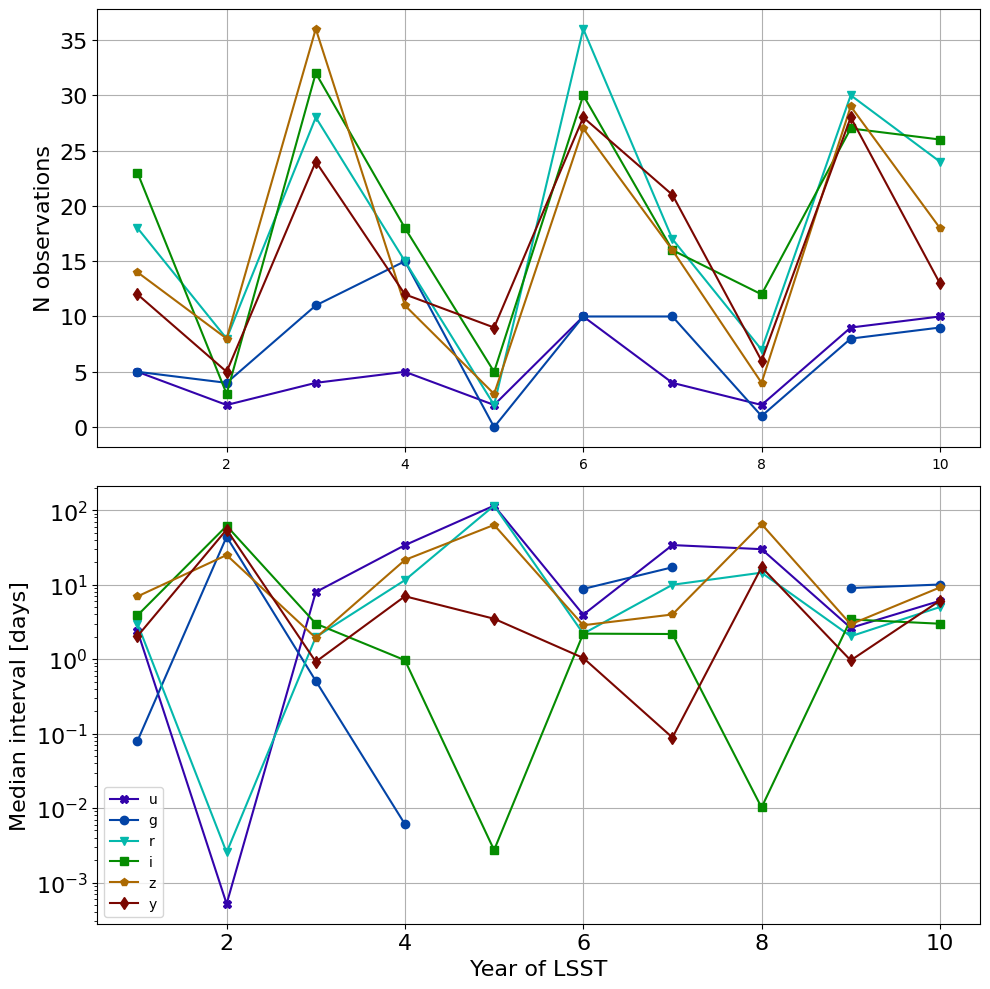

In [15]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.0)

for f in filters:
    data = obs_intervals[f]

    # Plot the number of observations
    axs[0].plot(data['Year'], data['Nobs'], c=PLOT_COLORS[f], marker=PLOT_SYMBOLS[f], ls='-')

    # Plot the interval between observations in each filter
    axs[1].plot(data['Year'], data['Median_interval'], c=PLOT_COLORS[f], marker=PLOT_SYMBOLS[f], ls='-', label=f)
    #axs.fill_between(data['Year'], data['Min_interval'], data['Max_interval'], color=PLOT_COLORS[f], alpha=0.1)
    #ax.errorbar(
    #    data['Year'], data['Median_interval'], 
    #    yerr=data['StdDev_interval'], 
    #    c=PLOT_COLORS[f], ls='none', alpha=0.5
    #)

axs[0].set_ylabel('N observations', fontsize=16)
axs[0].grid()
axs[0].tick_params(axis='y', labelsize=16) 

axs[1].set_xlabel('Year of LSST', fontsize=16)
axs[1].set_ylabel('Median interval [days]', fontsize=16)
axs[1].tick_params(axis='x', labelsize=16) 
axs[1].tick_params(axis='y', labelsize=16) 
axs[1].legend()
axs[1].grid()
axs[1].set_yscale('log')

plt.tight_layout()
plt.savefig('/Users/rstreet/cassiopeia/GrantProposals/2025/NSF_AAG/Howell_SNe/lsst_v5_cadence.png')

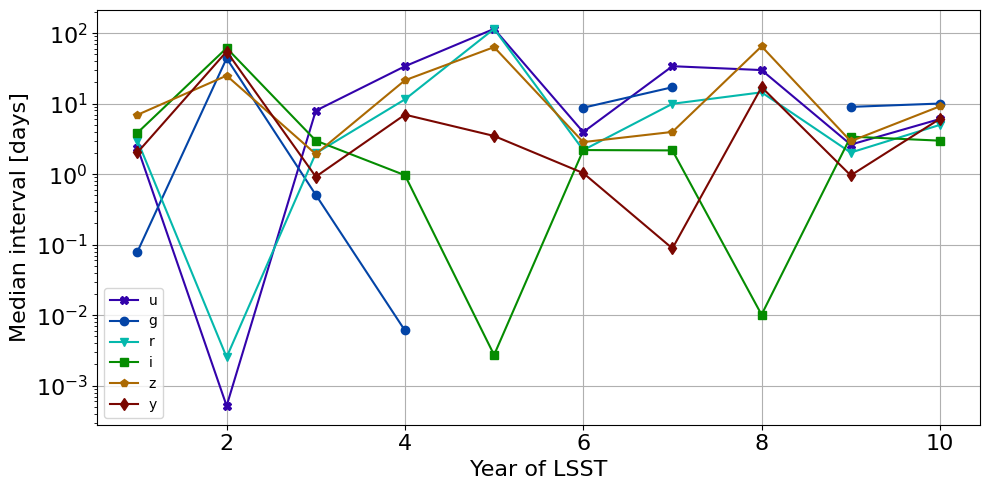

In [18]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

for f in filters:
    data = obs_intervals[f]
    
    # Plot the interval between observations in each filter
    axs.plot(data['Year'], data['Median_interval'], c=PLOT_COLORS[f], marker=PLOT_SYMBOLS[f], ls='-', label=f)

axs.set_xlabel('Year of LSST', fontsize=16)
axs.set_ylabel('Median interval [days]', fontsize=16)
axs.tick_params(axis='x', labelsize=16) 
axs.tick_params(axis='y', labelsize=16) 
axs.legend()
axs.grid()
axs.set_yscale('log')

plt.tight_layout()
plt.savefig('/Users/rstreet/cassiopeia/GrantProposals/2025/NSF_AAG/Howell_SNe/lsst_v5_median_interval.png')